# 1) Chargement des données

Import de Bibliotheques

In [1]:
# Manipulation des données
import pandas as pd
import numpy as np
import math
import os

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Statistiques & tests
from scipy import stats
from scipy.stats import shapiro

# Statsmodels (tests de diagnostic, VIF, modèles stats)
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# Pré-traitement
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Réduction dimensionnelle
from sklearn.decomposition import PCA

# Split des données
from sklearn.model_selection import train_test_split

# Modèles
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Pipeline + sauvegarde
from sklearn.pipeline import make_pipeline
import joblib

# Métriques / affichages
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score,
)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_billet = pd.read_csv('/content/drive/MyDrive/Formation DATA ANALYST/P12/billets.csv', sep=';')

# 2) Analyse exploratoire (EDA)


In [4]:
df_billet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
df_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
df_billet.isna().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,37
margin_up,0
length,0


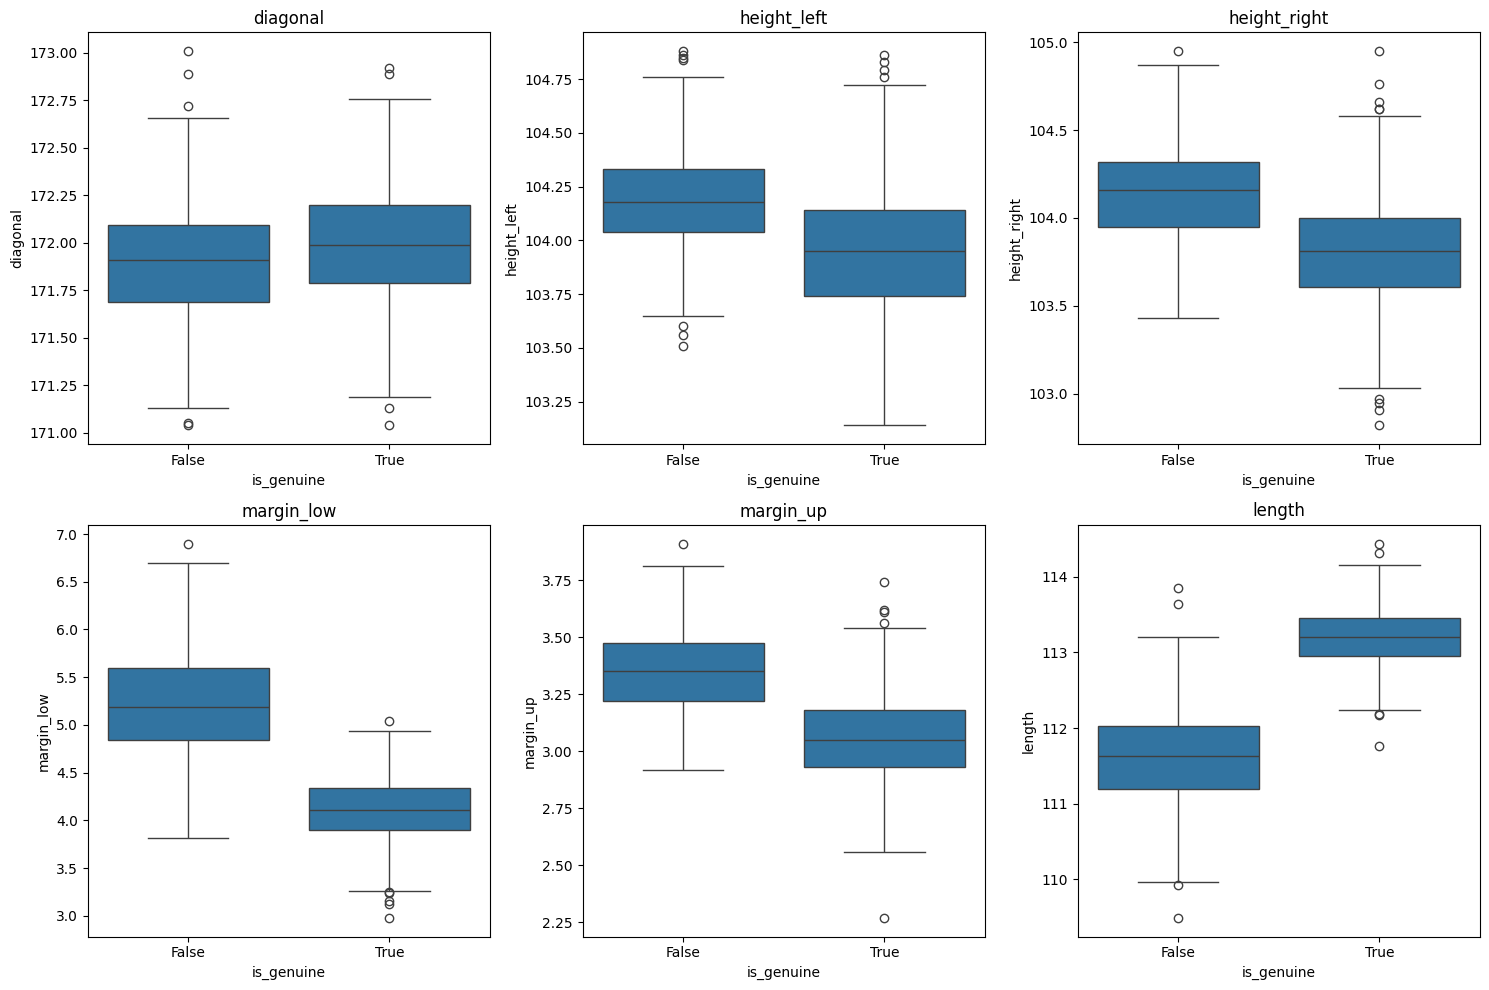

In [7]:
# Répartition de la cible (is_genuine)
genuine_counts = df_billet["is_genuine"].value_counts()

# Boxplots par variable selon la classe
features_cols = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

n_cols = 3
n_rows = int(np.ceil(len(features_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(features_cols):
    sns.boxplot(data=df_billet, x='is_genuine', y=col, ax=axes[i])
    axes[i].set_title(col)

# supprimer les axes vides
for j in range(len(features_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Cette étape d’EDA permet :
- de vérifier la répartition des classes (vrais/faux billets)
- d’identifier visuellement les variables les plus discriminantes via les boxplots

Les variables dont les distributions diffèrent fortement entre True et False sont de bons candidats prédictifs.

## Boxplot :
margin_low : séparation très nette entre les classes ; False a des valeurs plus élevées que True → variable très discriminante.

length : séparation nette ; True présente des longueurs plus élevées que False → variable très discriminante.

margin_up : différence visible mais chevauchement important → variable utile, mais moins forte seule.

height_left / height_right : distributions proches et fort chevauchement → faible pouvoir discriminant en univarié.

diagonal : médianes proches et recouvrement marqué → variable peu discriminante seule.

Outliers : quelques valeurs atypiques sur plusieurs variables, à garder en tête (vérification ou robustesse du modèle).

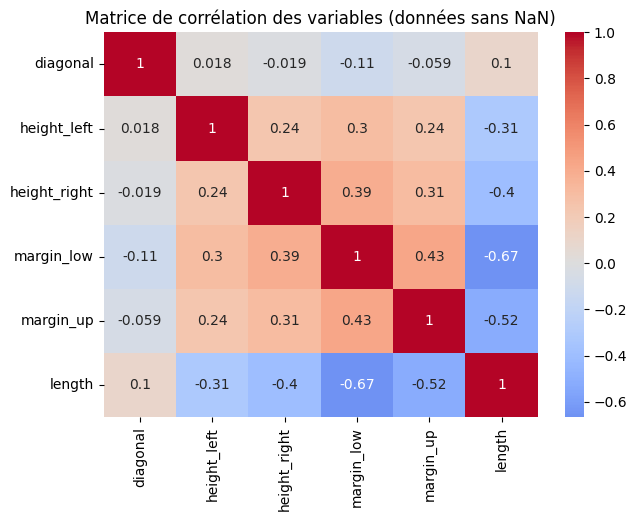

In [8]:
# Matrice de corrélation (sans les lignes avec NaN pour le calcul)
data_clean = df_billet.dropna()

corr_matrix = data_clean[[
    'diagonal', 'height_left', 'height_right',
    'margin_low', 'margin_up', 'length'
]].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matrice de corrélation des variables (données sans NaN)")
plt.show()


margin_low est fortement corrélée négativement à length (-0.67) → excellent candidat pour l’imputation.

margin_low est aussi corrélée positivement à margin_up (0.43) et height_right (0.39) → utiles en régression multiple.

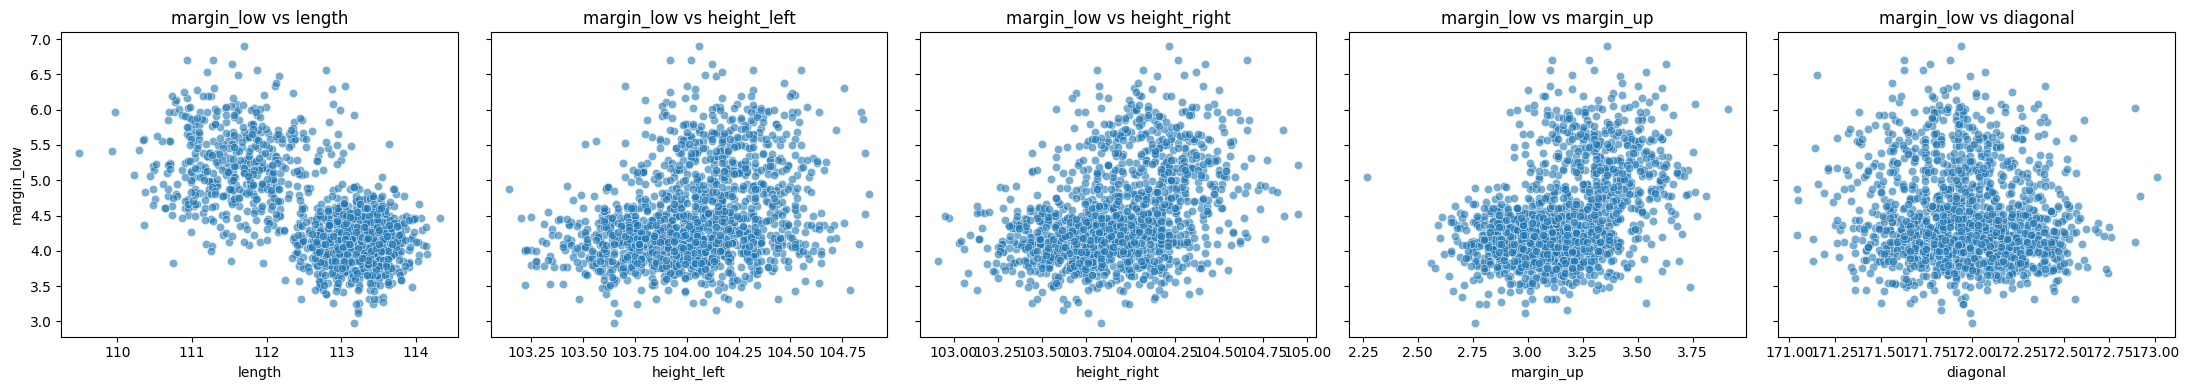

In [9]:
# Scatterplots pour analyser margin_low
independent_vars = ['length', 'height_left', 'height_right', 'margin_up', 'diagonal']

fig, axes = plt.subplots(1, len(independent_vars), figsize=(22, 4), sharey=True)

for idx, var in enumerate(independent_vars):
    sns.scatterplot(data=df_billet, x=var, y='margin_low', ax=axes[idx], alpha=0.6)
    axes[idx].set_title(f"margin_low vs {var}")
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel("margin_low")

plt.tight_layout()
plt.show()


# Régression linéaire simple

In [10]:
# Variable cible à imputer
target = "margin_low"

# Variables explicatives
features = [
    'diagonal',
    'height_left',
    'height_right',
    'margin_up',
    'length'
]

# Lignes sans NaN sur la cible
df_train = df_billet[df_billet[target].notna()]

# Lignes avec NaN sur la cible
df_missing = df_billet[df_billet[target].isna()]


In [11]:
X_train_imp = df_train[features]
y_train_imp = df_train[target]

lin_reg = LinearRegression()
lin_reg.fit(X_train_imp, y_train_imp)


LinearRegression()

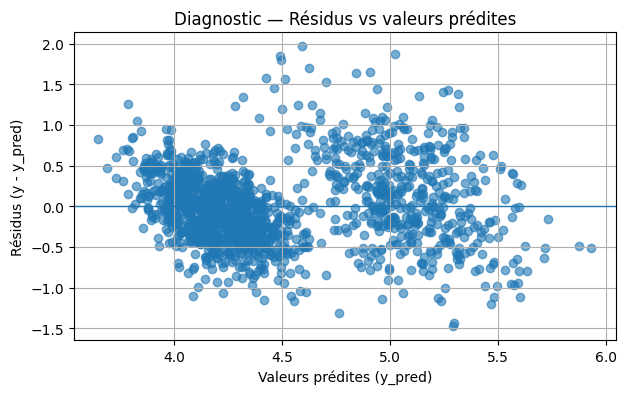

{'LM stat': np.float64(80.16261280175495), 'LM p-value': np.float64(7.759535216178539e-16), 'F stat': np.float64(16.89235884615446), 'F p-value': np.float64(2.922749656615172e-16)}


In [12]:
# Valeurs prédites sur le train (la ou margin_low est connu)
y_pred_train = lin_reg.predict(X_train_imp)

# Résidus du modèle
residuals = y_train_imp - y_pred_train

# Graphique
plt.figure(figsize=(7,4))
plt.scatter(y_pred_train, residuals, alpha=0.6)
plt.axhline(0, linewidth=1)
plt.xlabel("Valeurs prédites (y_pred)")
plt.ylabel("Résidus (y - y_pred)")
plt.title("Diagnostic — Résidus vs valeurs prédites")
plt.grid(True)
plt.show()

# Breusch–Pagan : nécessite une constante dans les variables explicatives
X_bp = sm.add_constant(X_train_imp)

bp_test = het_breuschpagan(residuals, X_bp)
labels = ["LM stat", "LM p-value", "F stat", "F p-value"]

print(dict(zip(labels, bp_test)))


Le test de Breusch–Pagan est significatif (p-value << 0.05), donc on rejette l’homoscédasticité : variance des résidus non constante.

Visuellement, le nuage de résidus n’a pas une dispersion uniforme : on observe une structure (deux groupes + dispersion variable), ce qui est cohérent avec une hétéroscédasticité.

# Test loi normale

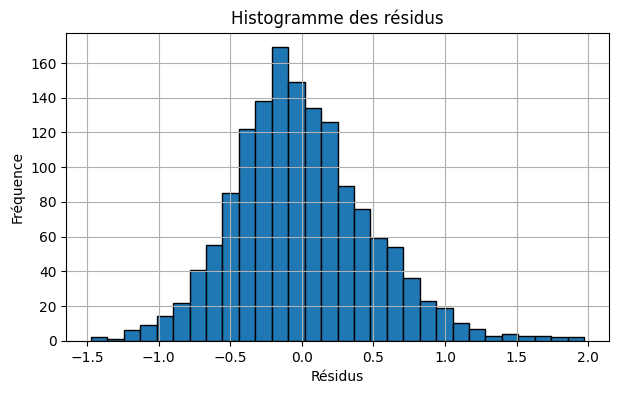

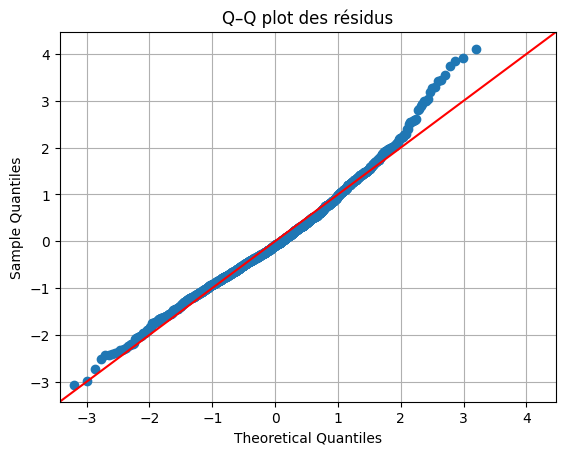

Shapiro-Wilk: stat=0.9858, p-value=8.54e-11


In [13]:
# Histogramme des résidus
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=30, edgecolor="black")
plt.title("Histogramme des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

# Q–Q plot
sm.qqplot(residuals, line="45", fit=True)
plt.title("Q–Q plot des résidus")
plt.grid(True)
plt.show()

# Shapiro-Wilk
stat, p = shapiro(residuals.sample(5000, random_state=42) if len(residuals) > 5000 else residuals)
print(f"Shapiro-Wilk: stat={stat:.4f}, p-value={p:.4g}")


# Test Co-linéarité

,Variable,VIF
5,length,1.576950
4,margin_up,1.404404
3,height_right,1.230115
2,height_left,1.138261
1,diagonal,1.013613


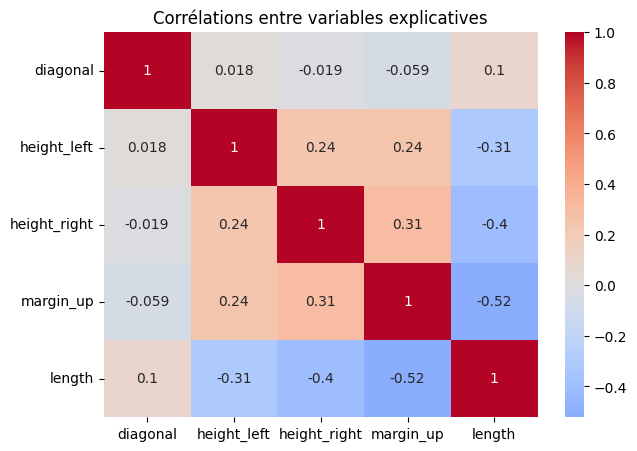

In [14]:
# Matrice explicative + constante
X_vif = sm.add_constant(X_train_imp)

vif = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# On retire la constante pour lecture
vif = vif[vif["Variable"] != "const"].sort_values("VIF", ascending=False)
display(vif)

plt.figure(figsize=(7,5))
sns.heatmap(X_train_imp.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Corrélations entre variables explicatives")
plt.show()

In [15]:
# Prédiction des valeurs manquantes
predicted_values = lin_reg.predict(df_missing[features])

# Imputation dans le DataFrame original
df_billet.loc[df_billet[target].isna(), target] = predicted_values


In [16]:
# Vérification
df_billet.isna().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,0
margin_up,0
length,0


# 3) Prétraitement

Le but est de transformer tes données brutes (les valeurs mesurées des billets) en données que les algorithmes de Machine Learning peuvent comprendre efficacement.


D'abord, il faut séparer les variables explicatives et la cible :

X = les mesures du billet (longueur, hauteur, diagonales…)

y = l’étiquette (vrai ou faux)

➡️ Pourquoi ?
Parce que le modèle doit apprendre à prédire y en fonction de X.

#Sélection des variables explicatives (X) et de la variable cible (y)

In [17]:
# X = variables explicatives - Y = cible
X = df_billet[['diagonal',
    'height_left',
    'height_right',
    'margin_low',
    'margin_up',
    'length']]
y = df_billet["is_genuine"]

#Découpage du jeu de données en train/test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 20 % des données en test
    random_state=42,    # pour que le split soit reproductible
    stratify=y          # conserve la proportion vrai/faux dans chaque échantillon
)

In [19]:
print("Dimensions de X_train et X_test :")
print(X_train.shape)
print(X_test.shape)

print("\nRépartition de y_train :")
print(y_train.value_counts(normalize=True))

print("\nRépartition de y_test :")
print(y_test.value_counts(normalize=True))


Dimensions de X_train et X_test :
(1200, 6)
(300, 6)

Répartition de y_train :
is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64

Répartition de y_test :
is_genuine
True     0.666667
False    0.333333
Name: proportion, dtype: float64


,n,n_true,n_false,% true,% false
Train,1200.000000,800.000000,400.000000,66.7%,33.3%
Test,300.000000,200.000000,100.000000,66.7%,33.3%


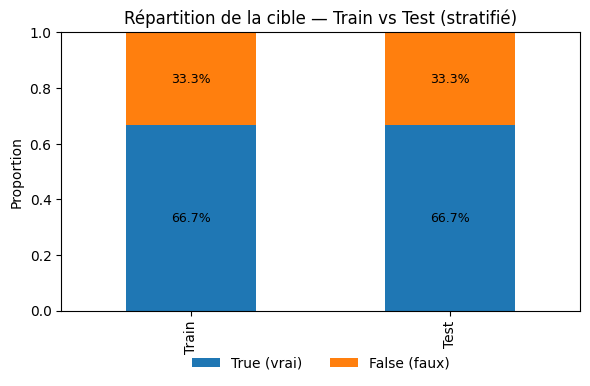

In [20]:
# Tableau récapitulatif (effectifs + proportions)
def _summary(y, name):
    vc = y.value_counts()
    vcn = y.value_counts(normalize=True)
    return pd.Series({
        "n": int(vc.sum()),
        "n_true": int(vc.get(True, 0)),
        "n_false": int(vc.get(False, 0)),
        "% true": float(vcn.get(True, 0) * 100),
        "% false": float(vcn.get(False, 0) * 100),
    }, name=name)

split_summary = pd.concat([
    _summary(y_train, "Train"),
    _summary(y_test, "Test")
], axis=1).T

display(split_summary.style.format({
    "% true": "{:.1f}%",
    "% false": "{:.1f}%"
}))

# Graphique
prop_df = pd.DataFrame({
    "True (vrai)": y_train.value_counts(normalize=True),
    "False (faux)": y_train.value_counts(normalize=True)
})

# Version propre : construire un tableau proportions train/test
prop_df = pd.DataFrame({
    "True (vrai)": [y_train.mean(), y_test.mean()],  # mean() marche car booléen
    "False (faux)": [1 - y_train.mean(), 1 - y_test.mean()]
}, index=["Train", "Test"])

ax = prop_df.plot(kind="bar", stacked=True, figsize=(6, 4))
ax.set_title("Répartition de la cible — Train vs Test (stratifié)")
ax.set_ylabel("Proportion")
ax.set_xlabel("")
ax.set_ylim(0, 1)

# Afficher les % sur les barres
for p in ax.patches:
    h = p.get_height()
    if h > 0.05:  # évite d'écrire sur des zones trop petites
        ax.text(
            p.get_x() + p.get_width()/2,
            p.get_y() + h/2,
            f"{h*100:.1f}%",
            ha="center", va="center", fontsize=9
        )

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
plt.tight_layout()
plt.show()


#Standardisation des valeurs

In [21]:
# Initialisation du scaler
scaler = StandardScaler()

# Fit + transform sur le train
X_train_scaled = scaler.fit_transform(X_train)

# Transform sur le test
X_test_scaled = scaler.transform(X_test)

# Conversion en DataFrame pour analyse
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Vérification du scaling
idx = ["mean", "std"]
X_train_scaled.describe().round(2).loc[idx, :]


,diagonal,height_left,height_right,margin_low,margin_up,length
mean,0.0,-0.0,0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


/tmp/ipython-input-1546163700.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(X_train.values, labels=X_train.columns, showfliers=False)
/tmp/ipython-input-1546163700.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(X_train_scaled.values, labels=X_train_scaled.columns, showfliers=False)


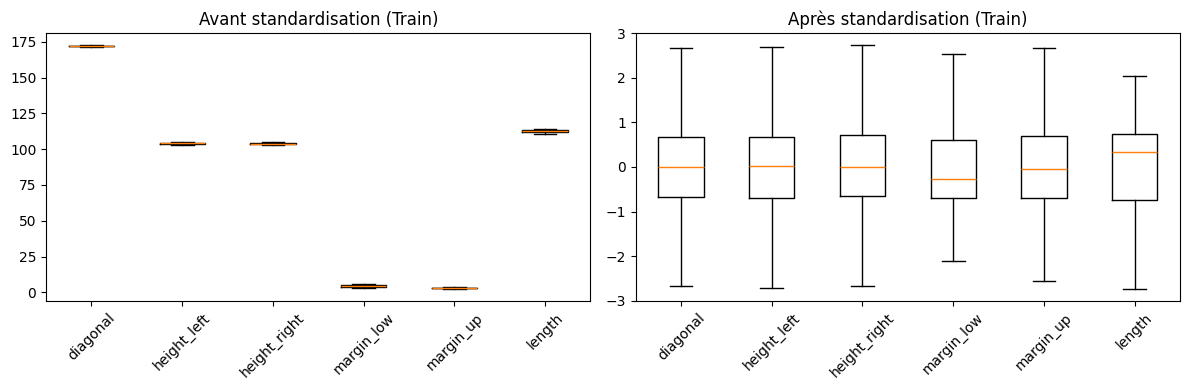

In [22]:
# Boxplot avant/après standardisation

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Avant scaling (train)
axes[0].boxplot(X_train.values, labels=X_train.columns, showfliers=False)
axes[0].set_title("Avant standardisation (Train)")
axes[0].tick_params(axis="x", rotation=45)

# Après scaling (train)
axes[1].boxplot(X_train_scaled.values, labels=X_train_scaled.columns, showfliers=False)
axes[1].set_title("Après standardisation (Train)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


# 4) Modélisation

Dans tous domaines, vous ne pouvez pas progresser si vous ne comprenez pas comment vos outils fonctionnent.

Avant d'utiliser les modèles mathématiques qui suivent, je vous recommande donc de visionner les vidéos suivantes:
* [StatQuest: Logistic Regression](https://www.youtube.com/watch?v=yIYKR4sgzI8)
* [StatQuest: K-nearest neighbors, Clearly Explained](https://youtu.be/HVXime0nQeI)
* [StatQuest: Random Forests Part 1 - Building, Using and Evaluating](https://youtu.be/J4Wdy0Wc_xQ)
* [StatQuest: Random Forests Part 2: Missing data and clustering](https://www.youtube.com/watch?v=sQ870aTKqiM)
* [StatQuest: K-means clustering](https://youtu.be/4b5d3muPQmA)

# Régression logistique

In [23]:
# 1) Initialisez une régression logistic.
    # Quels sont les paramètres ajustables de ce modèle ?
    # penalty : type de régularisation ('l2' par défaut, 'none', etc.)
    # C : force de la régularisation (inverse de la régularisation, plus C est grand, moins il y a de régularisation)
    # solver : algorithme d’optimisation ('lbfgs' par défaut, souvent très bien)
    # max_iter : nombre max d’itérations pour que l’algorithme converge
    # class_weight : permet de pondérer les classes (par ex. class_weight='balanced' en cas de déséquilibre)
    # random_state : pour la reproductibilité (dans certains solveurs)

    # Bien que vous puissez laisser la majorité d'entre eux par défaut,
    # il vaut mieux, à minima, ajuster `max_iter` pour plafonner le temps de calcul.

log_reg = LogisticRegression(max_iter=1000, random_state=42)

# 2) Entrainez le modèle avec vos données X_train et y_train

log_reg.fit(X_train_scaled, y_train)

# 3) Utiliser la régression logistique pour déterminer les vrais / faux billets de X_test.

y_pred_log = log_reg.predict(X_test_scaled)

# (optionnel mais utile pour la suite : probabilités, pour ROC/AUC)
y_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]


Classification report (Logistic Regression) :

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



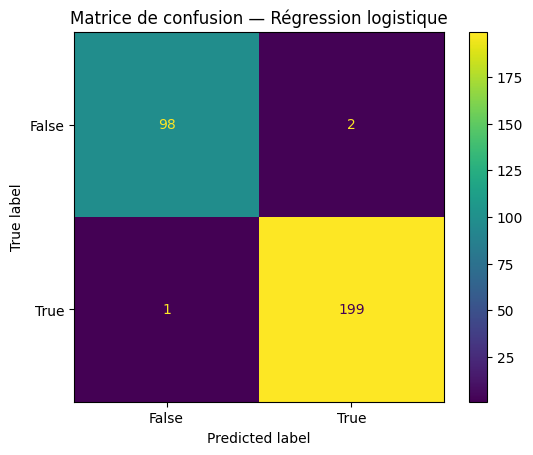

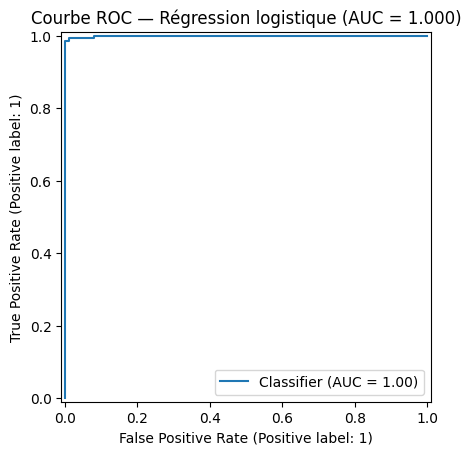

In [24]:
# Rapport de classification
print("Classification report (Logistic Regression) :\n")
print(classification_report(y_test, y_pred_log))

# Matrice de confusion
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log)
plt.title("Matrice de confusion — Régression logistique")
plt.show()

# ROC curve + AUC
auc = roc_auc_score(y_test, y_proba_log)
RocCurveDisplay.from_predictions(y_test, y_proba_log)
plt.title(f"Courbe ROC — Régression logistique (AUC = {auc:.3f})")
plt.show()


Les métriques (matrice de confusion, classification report, ROC/AUC) sont calculées sur y_test.

Avec test_size=0.2 et 1500 lignes, le jeu de test contient 300 billets (20%).
Le modèle est entraîné sur les 1200 billets restants (80%).

La courbe ROC mesure la capacité du modèle à séparer les classes pour tous les seuils possibles.
L'AUC résume cette capacité :
- 0.5 : hasard
- 1.0 : séparation parfaite

Ici AUC = 1.00 → le modèle distingue extrêmement bien vrais et faux billets.

,variable,coef,importance_abs,odds_ratio_+1std
5,length,3.685910,3.685910,39.881396
3,margin_low,-2.618812,2.618812,0.072889
4,margin_up,-1.631454,1.631454,0.195645
2,height_right,-0.642420,0.642420,0.526018
1,height_left,-0.353117,0.353117,0.702495
0,diagonal,0.181997,0.181997,1.199611


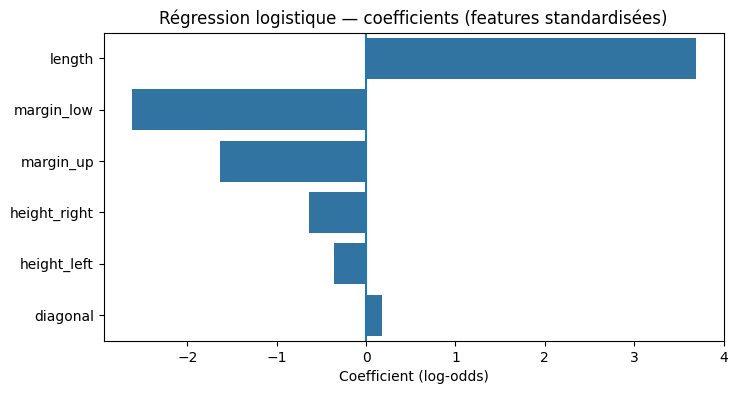

In [25]:
# Récupération des coefficients
coef_df = pd.DataFrame({
    "variable": X_train_scaled.columns,
    "coef": log_reg.coef_[0]
})

# Importance = valeur absolue du coefficient
coef_df["importance_abs"] = coef_df["coef"].abs()

# Odds ratio pour +1 écart-type sur la variable
coef_df["odds_ratio_+1std"] = np.exp(coef_df["coef"])

# Tri par importance décroissante
coef_df = coef_df.sort_values("importance_abs", ascending=False)

display(coef_df)

# Graphique des coefficients
plt.figure(figsize=(8, 4))
sns.barplot(data=coef_df, x="coef", y="variable")
plt.title("Régression logistique — coefficients (features standardisées)")
plt.xlabel("Coefficient (log-odds)")
plt.ylabel("")
plt.axvline(0)
plt.show()

Interprétation des coefficients (régression logistique)
Comme les variables ont été standardisées (moyenne=0, écart-type=1), les coefficients sont comparables entre eux.
- Signe du coefficient :
* coef > 0 : augmente la probabilité que le billet soit authentique (True)
* coef < 0 : diminue cette probabilité (donc pousse vers False)
- Importance : plus |coef| est grand, plus la variable influence la décision du modèle.

Ici, les variables les plus discriminantes sont :
- length (coef positif fort) : une longueur plus élevée (à +1 écart-type) augmente fortement la probabilité d’être True.
- margin_low (coef négatif fort) : une marge basse plus élevée (à +1 écart-type) diminue fortement la probabilité d’être True.

odds_ratio_+1std = exp(coef) donne un ordre de grandeur de l'effet :
- > 1 : augmente les chances d’être True
- < 1 : diminue les chances d’être True

Remarque : ces interprétations décrivent des tendances apprises sur l'échantillon.
Elles n'impliquent pas une causalité (une variable ne "cause" pas le fait qu'un billet soit vrai ou faux).


# KNN - K nearest neighbors

In [26]:
# Répéter les même étapes que pour la régression logistique mais avec le KNN.

# Initialiser le modèle (k par défaut : 5)
knn = KNeighborsClassifier(n_neighbors=5)

# Entraîner le modèle sur le train
knn.fit(X_train_scaled, y_train)

# Prédire sur le test
y_pred_knn = knn.predict(X_test_scaled)

# (ROC/AUC : probabilités)
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]


KNN classe un billet en regardant les k billets les plus proches dans l’espace des variables.

Ici, on utilise les variables standardisées : la distance est calculée sur des échelles comparables.

n_neighbors=5 signifie : décision basée sur les 5 voisins les plus proches.

Classification report (KNN) :

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       100
        True       0.99      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



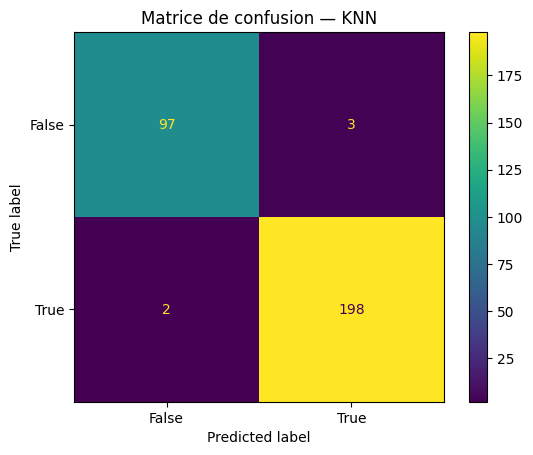

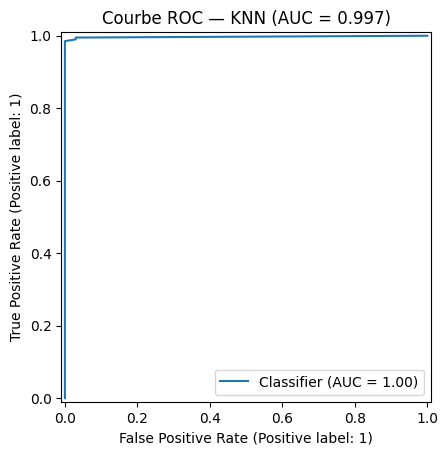

In [27]:
print("Classification report (KNN) :\n")
print(classification_report(y_test, y_pred_knn))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("Matrice de confusion — KNN")
plt.show()

auc_knn = roc_auc_score(y_test, y_proba_knn)
RocCurveDisplay.from_predictions(y_test, y_proba_knn)
plt.title(f"Courbe ROC — KNN (AUC = {auc_knn:.3f})")
plt.show()


# Random Forest

In [28]:
# hum... devinez ce qu'il faut faire 😁.

# Initialiser Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

# Entraîner le modèle (Random Forest n'a pas besoin de données standardisées)
rf.fit(X_train, y_train)

# Prédire sur le test
y_pred_rf = rf.predict(X_test)

# (ROC/AUC)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

Classification report (Random Forest) :

              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



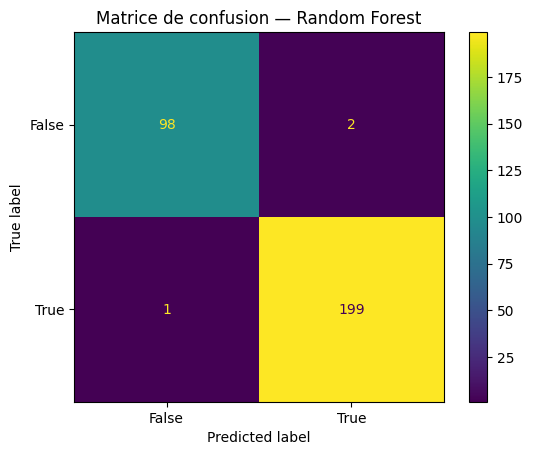

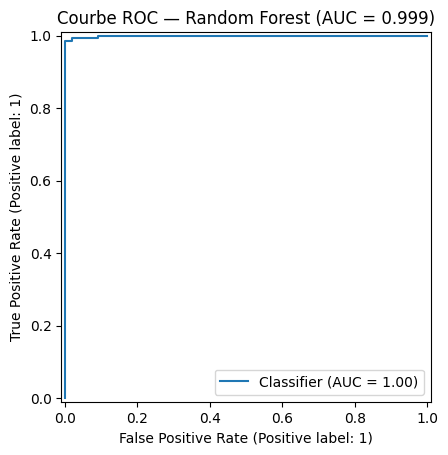

In [29]:
print("Classification report (Random Forest) :\n")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Matrice de confusion — Random Forest")
plt.show()

auc_rf = roc_auc_score(y_test, y_proba_rf)
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title(f"Courbe ROC — Random Forest (AUC = {auc_rf:.3f})")
plt.show()


# K-Means

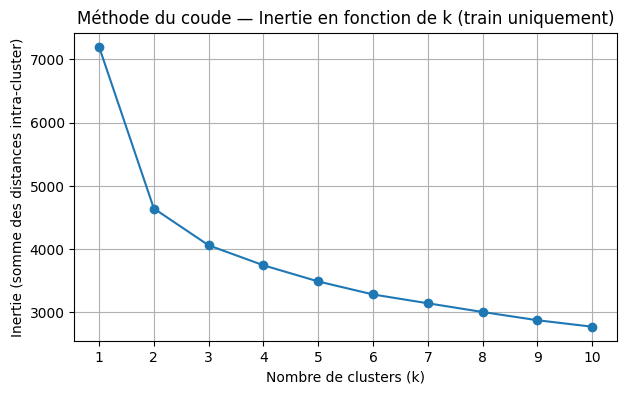

In [30]:
# Attention ! Cet algo est très différents de ceux utilisés précédemment.
# Peux-tu voir les différences ?
# Du coup, cet algo est-il utile (voir pertinent) pour cette étude ?

# Méthode du coude sur TRAIN uniquement (sans fuite)
inertias = []
k_values = range(1, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_scaled)              # train uniquement
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(list(k_values), inertias, marker='o')
plt.title("Méthode du coude — Inertie en fonction de k (train uniquement)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (somme des distances intra-cluster)")
plt.xticks(list(k_values))
plt.grid(True)
plt.show()

Accuracy KMeans (test) : 0.9866666666666667
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



,Prédit False,Prédit True
Réel False,98,2
Réel True,2,198


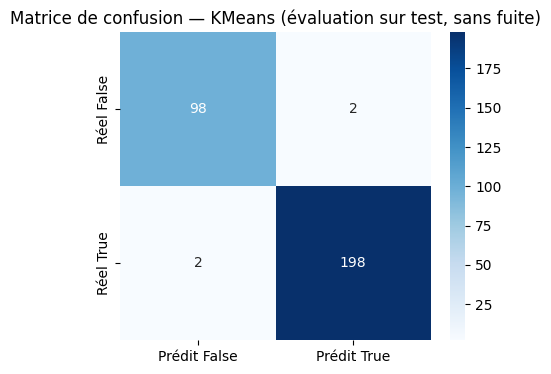

In [31]:
k_final = 2
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_scaled)

# Mapping cluster -> classe majoritaire (sur TRAIN uniquement)
df_train_km = pd.DataFrame({"is_genuine": y_train, "cluster": train_clusters}, index=y_train.index)
majority_map = pd.crosstab(df_train_km["cluster"], df_train_km["is_genuine"]).idxmax(axis=1).to_dict()

# Prédire clusters sur TEST puis convertir en prédiction de classe
test_clusters = kmeans.predict(X_test_scaled)
y_pred_km = pd.Series(test_clusters, index=y_test.index).map(majority_map)

# Évaluation sur TEST
print("Accuracy KMeans (test) :", accuracy_score(y_test, y_pred_km))
print(classification_report(y_test, y_pred_km))

cm = confusion_matrix(y_test, y_pred_km, labels=[False, True])
cm_df = pd.DataFrame(cm, index=["Réel False", "Réel True"], columns=["Prédit False", "Prédit True"])
display(cm_df)

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion — KMeans (évaluation sur test, sans fuite)")
plt.show()


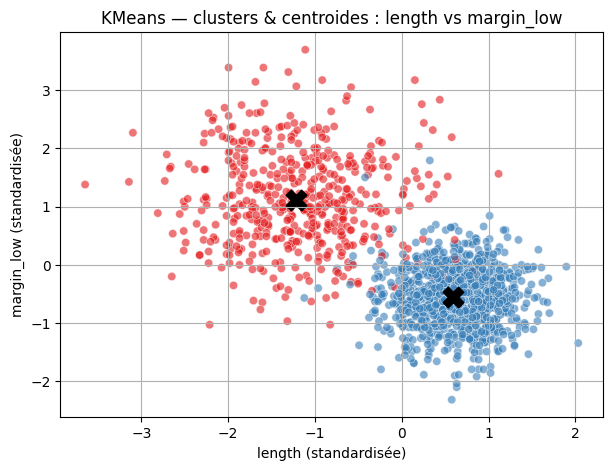

In [32]:
# Données à afficher : tous les points standardisés
X_all_scaled_df = pd.concat([X_train_scaled, X_test_scaled], axis=0)

# Labels de cluster (issus du modèle entraîné sur train)
clusters_all = kmeans.predict(X_all_scaled_df)

# Centroides
centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_all_scaled_df.columns)

# Choix de 2 variables pour la projection
x_var = "length"
y_var = "margin_low"

plt.figure(figsize=(7,5))

# Nuage de points : couleur = cluster
sns.scatterplot(
    x=X_all_scaled_df[x_var],
    y=X_all_scaled_df[y_var],
    hue=clusters_all,
    palette="Set1",
    alpha=0.6,
    legend=False
)

# Centroides
plt.scatter(
    centers[x_var], centers[y_var],
    marker="X", s=220, c="black" # s= taille
)

plt.title(f"KMeans — clusters & centroides : {x_var} vs {y_var}")
plt.xlabel(f"{x_var} (standardisée)")
plt.ylabel(f"{y_var} (standardisée)")
plt.grid(True)
plt.show()

# Sélection du meilleur modèle

Mais alors, quel est le meilleur modèle pour résoudre ce problème ?

Pour répondre à cette question, il vous faut bien comprendre l'intérêt de chacune des métriques d'évaluation qui existent pour ce type de problème.

Vous me voyez venir... 😎 : StatQuest !!! 🤩
* [Machine Learning Fundamentals: Sensitivity and Specificity
](https://youtu.be/vP06aMoz4v8)
* [Machine Learning Fundamentals: The Confusion Matrix](https://youtu.be/Kdsp6soqA7o)
* [ROC and AUC, Clearly Explained!](https://youtu.be/4jRBRDbJemM)

Vous avez aussi des petits modules sympathiques sur Sklearn qui vous machent grandement le travail:
* [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
* [Confusion Matrix Display](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
* [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

A vous de jouer ! 🚀

In [33]:
# C'est là qu'on voit qui sont les bons 😉!

In [34]:
def eval_model(name, y_true, y_pred, y_proba_true=None):
    """
    y_true, y_pred: bool (False/True)
    y_proba_true: proba de la classe True (optionnel)
    """
    cm = confusion_matrix(y_true, y_pred, labels=[False, True])
    tn, fp, fn, tp = cm.ravel()  # tn: False→False ; fp: False→True ; fn: True→False ; tp: True→True

    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    out = {
        "Modèle": name,
        "Accuracy": accuracy_score(y_true, y_pred),

        # Metrics "classiques" (classe True)
        "Precision (True)": rep["True"]["precision"],
        "Recall (True)": rep["True"]["recall"],
        "F1 (True)": rep["True"]["f1-score"],

        # Metrics utiles si on veut surtout détecter les faux billets (classe False)
        "Recall (False)": rep["False"]["recall"],
        "F1 (False)": rep["False"]["f1-score"],

        # Erreurs de confusion (les plus parlantes)
        "Faux billets laissés passer (False→True)": fp,
        "Vrais billets rejetés (True→False)": fn,
    }

    # AUC (si probabilités disponibles)
    if y_proba_true is not None:
        y_true_int = y_true.astype(int)  # True=1, False=0
        out["AUC (True)"] = roc_auc_score(y_true_int, y_proba_true)

        # AUC orientée "détection des faux" (False)
        y_false = (~y_true).astype(int)      # False=1
        proba_false = 1 - y_proba_true
        out["AUC (False)"] = roc_auc_score(y_false, proba_false)
    else:
        out["AUC (True)"] = np.nan
        out["AUC (False)"] = np.nan

    return out

# Liste des modèles à comparer
results = []
results.append(eval_model("Logistic Regression", y_test, y_pred_log, y_proba_log))
results.append(eval_model("KNN (k=5)", y_test, y_pred_knn, y_proba_knn))
results.append(eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf))
results.append(eval_model("KMeans (k=2)", y_test, y_pred_km, None))  # pas de proba fiable

results_df = pd.DataFrame(results)

# Tri recommandé si risque principal = laisser passer des faux billets
results_df = results_df.sort_values(
    by=["Faux billets laissés passer (False→True)", "Recall (False)", "AUC (False)"],
    ascending=[True, False, False]
)

display(results_df.style.format({
    "Accuracy": "{:.3f}",
    "Precision (True)": "{:.3f}",
    "Recall (True)": "{:.3f}",
    "F1 (True)": "{:.3f}",
    "Recall (False)": "{:.3f}",
    "F1 (False)": "{:.3f}",
    "AUC (True)": "{:.3f}",
    "AUC (False)": "{:.3f}",
}))

,Modèle,Accuracy,Precision (True),Recall (True),F1 (True),Recall (False),F1 (False),Faux billets laissés passer (False→True),Vrais billets rejetés (True→False),AUC (True),AUC (False)
0,Logistic Regression,0.990,0.990,0.995,0.993,0.980,0.985,2,1,1.000,0.999
2,Random Forest,0.990,0.990,0.995,0.993,0.980,0.985,2,1,0.999,0.999
3,KMeans (k=2),0.987,0.990,0.990,0.990,0.980,0.980,2,2,nan,nan
1,KNN (k=5),0.983,0.985,0.990,0.988,0.970,0.975,3,2,0.997,0.997


In [35]:
def eval_model(name, y_true, y_pred, y_proba_true=None):
    cm = confusion_matrix(y_true, y_pred, labels=[False, True])
    tn, fp, fn, tp = cm.ravel()

    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    out = {
        "Modèle": name,

        # Synthèse lisible
        "Accuracy": accuracy_score(y_true, y_pred),

        # Focus métier : détecter les faux (classe False)
        "Recall (False)": rep["False"]["recall"],
        "F1 (False)": rep["False"]["f1-score"],

        # Erreurs les plus parlantes
        "Faux billets laissés passer (False→True)": fp,  # FP
        "Vrais billets rejetés (True→False)": fn,        # FN
    }

    # Une seule AUC (on prend la classe True par convention)
    if y_proba_true is not None:
        out["AUC"] = roc_auc_score(y_true.astype(int), y_proba_true)
    else:
        out["AUC"] = np.nan

    return out

# Construire le tableau
results = [
    eval_model("Logistic Regression", y_test, y_pred_log, y_proba_log),
    eval_model("Random Forest",      y_test, y_pred_rf,  y_proba_rf),
    eval_model("KMeans (k=2)",       y_test, y_pred_km,  None),
    eval_model("KNN (k=5)",          y_test, y_pred_knn, y_proba_knn),
]
results_df = pd.DataFrame(results)

# Hiérarchie métier (priorité aux faux laissés passer)
results_df = results_df.sort_values(
    by=[
        "Faux billets laissés passer (False→True)",  # 1) FP (min)
        "Vrais billets rejetés (True→False)",        # 2) FN (min)
        "Recall (False)",                            # 3) détecter les faux (max)
        "AUC",                                       # 4) séparation (max)
    ],
    ascending=[True, True, False, False],
    na_position="last"
).reset_index(drop=True)

# Affichage formaté
display(results_df.style.format({
    "Accuracy": "{:.3f}",
    "Recall (False)": "{:.3f}",
    "F1 (False)": "{:.3f}",
    "AUC": "{:.3f}",
}))

,Modèle,Accuracy,Recall (False),F1 (False),Faux billets laissés passer (False→True),Vrais billets rejetés (True→False),AUC
0,Logistic Regression,0.990,0.980,0.985,2,1,1.000
1,Random Forest,0.990,0.980,0.985,2,1,0.999
2,KMeans (k=2),0.987,0.980,0.980,2,2,nan
3,KNN (k=5),0.983,0.970,0.975,3,2,0.997


# Sauvegarde du meilleur modèle

**_ATTENTION_** :
```
Sauvegarder un modèle implique de sauvegarder aussi les étapes de préprocessing des données.
Dans votre cas, vous devez donc inclure, à minima, votre StandardScaler.
```
Voir [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) pour plus d'infos.

In [36]:
# Utilisez make_pipeline pour inclure toutes les étapes nécessaires
# à la prédiction de si un billet est vrai ou faux.

# Sauvegardez votre modèle à l'aide de la librairie joblib.

In [37]:
# Pipeline

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# On fige la liste des variables utilisées par le modèle (doit correspondre à X)
FEATURES = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

# Pipeline robuste :
# - SimpleImputer: ne change rien si le fichier est complet, mais remplace les NaN sinon
# - StandardScaler: indispensable pour LR (et exigé par la consigne au minimum)
# - LogisticRegression: meilleur modèle retenu
best_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)


In [38]:
# Entraînement + vérification rapide

from sklearn.metrics import confusion_matrix, classification_report

# Entraînement (X_train NON standardisé : le scaler est dans la pipeline)
best_pipeline.fit(X_train[FEATURES], y_train)

# Vérification rapide sur le test
y_pred_final = best_pipeline.predict(X_test[FEATURES])

print("Matrice de confusion (final pipeline) :")
print(confusion_matrix(y_test, y_pred_final, labels=[False, True]))

print("\nRapport de classification (final pipeline) :")
print(classification_report(y_test, y_pred_final))

Matrice de confusion (final pipeline) :
[[ 98   2]
 [  1 199]]

Rapport de classification (final pipeline) :
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [39]:
# Sauvegarde robuste avec joblib

import os
import joblib

artifact = {
    "model": best_pipeline,
    "features": FEATURES
}

SAVE_DIR = "/content/drive/MyDrive/Formation DATA ANALYST/P12"
os.makedirs(SAVE_DIR, exist_ok=True)

joblib.dump(artifact, f"{SAVE_DIR}/billets_artifact.joblib")
print("Artefact sauvegardé :", f"{SAVE_DIR}/billets_artifact.joblib")



Artefact sauvegardé : /content/drive/MyDrive/Formation DATA ANALYST/P12/billets_artifact.joblib
